In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
from ExternalFunctions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = '../../../../'
path_S1 = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/Station 1/'
path_S2 = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/Station 2/'

MA1 = read_csv_BC(f'{path_S1}MA200/', parent_path, -1)
MA2 = read_csv_BC(f'{path_S2}MA200/', parent_path, -1)
MA1['MA200-0369_241217094901'] = pd.concat([MA1['MA200-0369_241217094901'], MA1['MA200-0369_241217101259']], ignore_index=True)

timestamps_MA = [['2024-12-10 09:15:00', '2024-12-10 16:00:00'],
                 ['2024-12-11 09:00:00', '2024-12-11 16:00:00'],
                 ['2024-12-12 09:00:00', '2024-12-12 16:00:00'],
                 ['2024-12-13 08:45:00', '2024-12-13 14:00:00'],
                 ['2024-12-16 09:45:00', '2024-12-16 15:45:00'],
                 ['2024-12-17 09:15:00', '2024-12-17 15:45:00']]

MA1_dict_keys = ['MA200-0369_000301200101', 'MA200-0369_241210105000', 'MA200-0369_241211095501', 'MA200-0369_241212094705', 
                 'MA200-0369_241213094000', 'MA200-0369_241216103300', 'MA200-0369_241217094901']
MA2_dict_keys = ['MA200-0285_241209120400', 'MA200-0285_241210105200', 'MA200-0285_241211093400', 'MA200-0285_241212093100', 
                 'MA200-0285_241213092900', 'MA200-0285_241216102104', 'MA200-0285_241217101400']

In [3]:
NS1 = read_SMPS(path_S1, parent_path, [-1, 0])
OPS1 = read_OPS(f'{path_S1}OPS/', parent_path, 0)
NS2 = read_SMPS(path_S2, parent_path, [-1, 0])
OPS2 = read_OPS(path_S2+'OPS/', parent_path, 0)

NS_dict_keys = ['2024-12-09_NanoScan', '2024-12-10_NanoScan', '2024-12-11_NanoScan', '2024-12-12_NanoScan', 
                '2024-12-13_NanoScan', '2024-12-16_NanoScan', '2024-12-17_NanoScan']
NS_bins = NS1['2024-12-06_NanoScan'].keys()[3:16].to_list()

OPS1_dict_keys = ['OPS1-CPH-d1', 'OPS1-CPH-d2', 'OPS1-CPH-d3', 'OPS1-CPH-d4', 'OPS1-CPH-d5', 'OPS1-NP-d1', 'OPS1-NP-d2'] # 'OPS1-CPH-n3', 'OPS1-CPH-n4'
OPS2_dict_keys = ['OPS2-CPH-d1', 'OPS2-CPH-d2', 'OPS2-CPH-d3', 'OPS2-CPH-d4', 'OPS2-CPH-d5', 'OPS2-NP-d1', 'OPS2-NP-d2']
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_keys = OPS1['OPS1-HEPA'].keys()[1:17].to_list()

OPS1['OPS1-CPH-d5'] = pd.concat([OPS1['OPS1-CPH-d5-1'], OPS1['OPS1-CPH-d5-2']], ignore_index=True)
OPS1['OPS1-NP-d2'] = pd.concat([OPS1['OPS1-NP-d2-1'], OPS1['OPS1-NP-d2-2']], ignore_index=True)
OPS2['OPS2-CPH-d3'] = pd.concat([OPS2['OPS2-CPH-d3-1'], OPS2['OPS2-CPH-d3-2']], ignore_index=True)
OPS2['OPS2-CPH-d3'] = pd.concat([OPS2['OPS2-CPH-d3'], OPS2['OPS2-CPH-d3-3']], ignore_index=True)

NS1_bg_mean, NS1_bg_std, NS1_bg_error = bin_mean(['2024-12-06 11:05:00', '2024-12-06 11:45:00'], 
                                              NS1['2024-12-06_NanoScan'], NS_bins, 'Time', 0.1)
for key in NS_dict_keys:
    df = NS1[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS1_bg_mean[i]
    NS1[key] = df

NS2_bg_mean, NS2_bg_std, NS2_bg_error = bin_mean(['2024-12-06 11:05:00', '2024-12-06 11:45:00'], 
                                              NS2['2024-12-06_NanoScan'], NS_bins, 'Time', 0.1)
for key in NS_dict_keys:
    df = NS2[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS2_bg_mean[i]
    NS2[key] = df

OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]

for dict_key1, dict_key2 in zip(OPS1_dict_keys, OPS2_dict_keys):
    for old_key, new_key in zip(OPS_keys, OPS_mid_point):
        OPS1[dict_key1] = OPS1[dict_key1].rename(columns = {old_key: new_key})
        OPS2[dict_key2] = OPS2[dict_key2].rename(columns = {old_key: new_key})

NS_bin_mean = []
for key in NS_bins:
    NS_bin_mean.append(float(key) / 1000)

In [4]:
timestamps = [['2024-12-09 12:00:00', '2024-12-09 16:30:00'],
              ['2024-12-10 09:15:00', '2024-12-10 16:00:00'],
              ['2024-12-11 09:00:00', '2024-12-11 16:00:00'],
              ['2024-12-12 09:00:00', '2024-12-12 16:00:00'],
              ['2024-12-13 08:45:00', '2024-12-13 14:00:00'],
              ['2024-12-16 09:45:00', '2024-12-16 15:45:00'],
              ['2024-12-17 09:15:00', '2024-12-17 15:45:00']]

NS_OPS_number1, NS_OPS_mass1, NS_OPS_keys, NS_OPS_bin_mean = merge_data(NS1, NS_dict_keys, [3, 15], OPS1, OPS1_dict_keys, [1, 17], timestamps, ['Time', 'Time'], False, True)
NS_OPS_number2, NS_OPS_mass2, NS_OPS_keys, NS_OPS_bin_mean = merge_data(NS2, NS_dict_keys, [3, 15], OPS2, OPS2_dict_keys, [1, 17], timestamps, ['Time', 'Time'], False, True)

print(NS_OPS_keys[12:])
print(NS_OPS_mass1.keys())

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

[0.337, 0.419, 0.522, 0.65, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
dict_keys(['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6', 'Exp7'])


2024-12-10
<ValueView p=366.6418771967341 mu=1.3329980139192614 sigma=0.34539556286132506>
<ValueView p=135.8211651590698 mu=1.2779451972867935 sigma=0.615029171060908>
2024-12-11
<ValueView p=423.61103700683805 mu=1.1491349087212668 sigma=0.14246321047746852>
<ValueView p=308.6201296996415 mu=1.2889624948241027 sigma=0.8481907578143584>
2024-12-12
<ValueView p1=107.09201796096406 mu1=1.3934081840233425 sigma1=0.3333236788516356 p2=315.6286422564653 mu2=1.1835934219954816 sigma2=0.12551558286916922>
<ValueView p1=208.7882593310412 mu1=0.9916396628554963 sigma1=0.3883988299750108 p2=196.11723130853824 mu2=1.0832105695280008 sigma2=0.09492609380356852>
2024-12-13
<ValueView p1=261.03443893224306 mu1=1.0863388347029979 sigma1=0.05738004868783493 p2=54.44091054325002 mu2=1.1394703336059588 sigma2=0.11191856311678627>
<ValueView p=299.1673666069181 mu=0.896935867178965 sigma=0.6721916487843981>
2024-12-16
<ValueView p1=235.86413512341304 mu1=1.0240414262895707 sigma1=0.04810527261730017 p2=

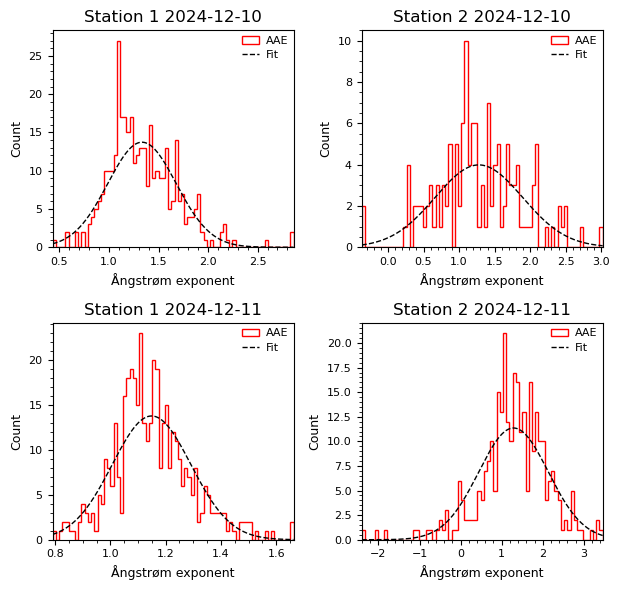

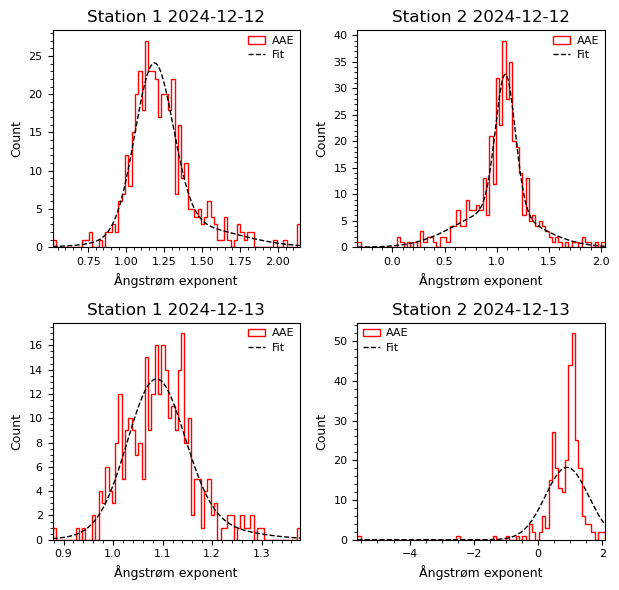

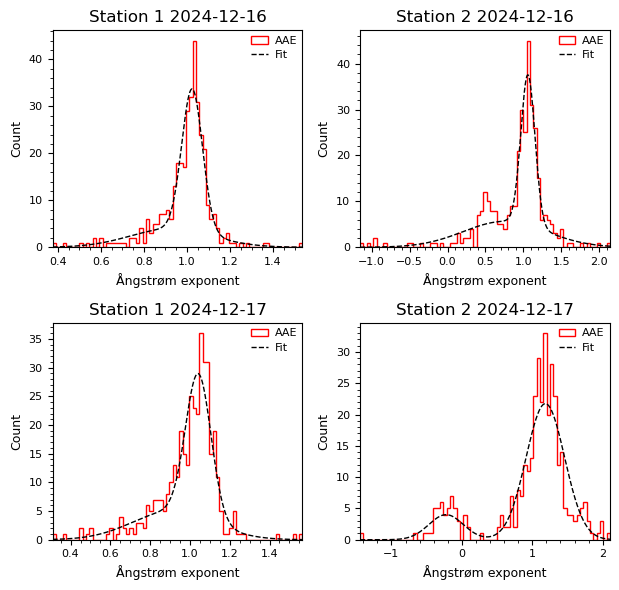

In [7]:
Nbins = 75

fig1, ax1 = plt.subplots(2, 2, figsize = (6.3, 6))
fig2, ax2 = plt.subplots(2, 2, figsize = (6.3, 6))
fig3, ax3 = plt.subplots(2, 2, figsize = (6.3, 6))

initial1 = [{'p': 350, 'mu': 2, 'sigma': 0.5},
            {'p': 250, 'mu': 2, 'sigma': 0.5},
            {'p': 400, 'mu': 2, 'sigma': 0.5},
            {'p': 400, 'mu': 2, 'sigma': 0.5}]
initial2 = [{'p1': 500,  'mu1': 1.25, 'sigma1': 0.5, 'p2': 100,  'mu2': 1.5, 'sigma2': 0.1},
            {'p1': 400,  'mu1': 1.1, 'sigma1': 0.1, 'p2': 200,  'mu2': 1.05, 'sigma2': 0.1},
            {'p1': 300,  'mu1': 1.1, 'sigma1': 0.3, 'p2': 100,  'mu2': 0.8, 'sigma2': 0.05},
            {'p': 400,  'mu': 1, 'sigma': 0.05}]
initial3 = [{'p1': 300, 'mu1': 1, 'sigma1': 0.1, 'p2': 100, 'mu2': 0.5,'sigma2': 0.1},
            {'p1': 300, 'mu1': 1.1, 'sigma1': 0.1, 'p2': 100, 'mu2': 0.5,'sigma2': 0.1},
            {'p1': 300, 'mu1': 1, 'sigma1': 0.5, 'p2': 100, 'mu2': 0.1,'sigma2': 0.5},
            {'p1': 500, 'mu1': 1.5, 'sigma1': 0.1, 'p2': 100, 'mu2': -0.3,'sigma2': 0.1}]
func2 = [d_gauss, gauss]

for i, key in enumerate(MA1_dict_keys[1:]):
    date = timestamps_MA[i][0].split(' ')[0]
    print(date)

    if i < 2:

        AAE_hist(ax1[i][0], MA1[key], timestamps_MA[i], Nbins, gauss, initial1[i])
        AAE_hist(ax1[i][1], MA2[MA2_dict_keys[i+1]], timestamps_MA[i], Nbins, gauss, initial1[i+2])

        ax1[i][0].set_title('Station 1 ' + date)
        ax1[i][1].set_title('Station 2 ' + date)

        fig1.tight_layout()
        fig1.savefig('Gaussian_fits/AAE_CPH_hall.png', dpi = 600)

    if 1 < i < 4:

        AAE_hist(ax2[i-2][0], MA1[key], timestamps_MA[i], Nbins, func2[0], initial2[i-2])
        AAE_hist(ax2[i-2][1], MA2[MA2_dict_keys[i+1]], timestamps_MA[i], Nbins, func2[i-2], initial2[i])

        ax2[i-2][0].set_title('Station 1 ' + date)
        ax2[i-2][1].set_title('Station 2 ' + date)

        fig2.tight_layout()
        fig2.savefig('Gaussian_fits/AAE_CPH_platform.png', dpi = 600)

    if i > 3:
                         
        AAE_hist(ax3[i-4][0], MA1[key], timestamps_MA[i], Nbins, d_gauss, initial3[i-4])
        AAE_hist(ax3[i-4][1], MA2[MA2_dict_keys[i+1]], timestamps_MA[i], Nbins, d_gauss, initial3[i-2])

        ax3[i-4][0].set_title('Station 1 ' + date)
        ax3[i-4][1].set_title('Station 2 ' + date)

        fig3.tight_layout()
        fig3.savefig('Gaussian_fits/AAE_NP.png', dpi = 600)

In [6]:
# fig1, ax1 = plt.subplots(3, 2, figsize = (6.3, 8))
# fig2, ax2 = plt.subplots(2, 2, figsize = (6.5, 5.5))
# fig3, ax3 = plt.subplots(2, 2, figsize = (6.5, 5.5))

# for i in range(7):
#     date = timestamps[i][0].split(' ')[0]
#     key = 'Exp' + str(i+1)

#     if i < 3:
#         y_max = 4*10**4

#         n1, en, m1, em, ax_1, ax2_1 = plot_bin_mean(ax1[i][0], timestamps[i], NS_OPS_number1[key], NS_OPS_mass1[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)
#         n2, en, m2, em, ax_2, ax2_2 = plot_bin_mean(ax1[i][1], timestamps[i], NS_OPS_number2[key], NS_OPS_mass2[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)

#         ax_1.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_1.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_1.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)
#         ax_2.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_2.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_2.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

#         ax_1.set(title = 'Station 1 ' + date, ylim = (0, y_max))
#         ax_2.set(title = 'Station 2 ' + date, ylim = (0, y_max))
#         ax2_1.set_ylim(0, 55)
#         ax2_2.set_ylim(0, 55)

#         fig1.tight_layout()
#         fig1.savefig('Gaussian_fits/NS_OPS_fitted_CPH_hall.png', dpi = 600)

#     if 2 < i < 5:
#         y_max = 5*10**4
#         n1, en, m1, em, ax_1, ax2_1 = plot_bin_mean(ax2[i-3][0], timestamps[i], NS_OPS_number1[key], NS_OPS_mass1[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)
#         n2, en, m2, em, ax_2, ax2_2 = plot_bin_mean(ax2[i-3][1], timestamps[i], NS_OPS_number2[key], NS_OPS_mass2[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)

#         ax_1.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_1.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_1.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)
#         ax_2.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_2.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_2.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

#         ax_1.set(title = 'Station 1 ' + date, ylim = (0, y_max))
#         ax_2.set(title = 'Station 2 ' + date, ylim = (0, y_max))
#         ax2_1.set_ylim(0, 80)
#         ax2_2.set_ylim(0, 80)

#         fig2.tight_layout()
#         fig2.savefig('Gaussian_fits/NS_OPS_fitted_CPH_platform.png', dpi = 600)

#     if i > 4:
#         y_max = 6.5*10**4

#         n1, en, m1, em, ax_1, ax2_1 = plot_bin_mean(ax3[i-5][0], timestamps[i], NS_OPS_number1[key], NS_OPS_mass1[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)
#         n2, en, m2, em, ax_2, ax2_2 = plot_bin_mean(ax3[i-5][1], timestamps[i], NS_OPS_number2[key], NS_OPS_mass2[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, NS_OPS_cut, 0.15, 0.3, True)

#         ax_1.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_1.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_1.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)
#         ax_2.vlines(0.3, 0, y_max + 10, colors = 'darkgrey', linestyles = '--')
#         ax_2.text(0.25, y_max - 0.1*y_max, 'NanoScan', ha = 'right', fontsize = 9)
#         ax_2.text(0.35, y_max - 0.1*y_max, 'OPS', ha = 'left', fontsize = 9)

#         ax_1.set(title = 'Station 1 ' + date, ylim = (0, y_max))
#         ax_2.set(title = 'Station 2 ' + date, ylim = (0, y_max))
#         ax2_1.set_ylim(0, 95)
#         ax2_2.set_ylim(0, 85)

#         fig3.tight_layout()
#         fig3.savefig('Gaussian_fits/NS_OPS_fitted_NP.png', dpi = 600)